In [40]:
import os
import math
import json
import random
import datetime
import time
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, normalized_mutual_info_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

# Custom
import lightgbm as lgb
import shap

In [41]:
# From: https://github.com/hpi-dhc/jaime
''' computes the normalized mutual information (NMI) matrix '''
def compute_nmi(data, reference_columns):    
    discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
    ''' necessary in case a given column is not available '''
    for column in [column for column in reference_columns if not column in data.columns]:
        data[column] = np.zeros(data.shape[0])
    data_discretized = data[reference_columns]
    data_discretized[reference_columns] = discretizer.fit_transform(data[reference_columns])
    nmi_matrix = np.zeros((len(data_discretized.columns), len(data_discretized.columns)))

    for i in range(len(data_discretized.columns)):
        for j in range(len(data_discretized.columns)):
            col1 = data_discretized.columns[i]
            col2 = data_discretized.columns[j]
            nmi_matrix[i, j] = normalized_mutual_info_score(data_discretized[col1], 
                                                            data_discretized[col2], 
                                                            average_method='max')
    return nmi_matrix

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def drop_correlation(df, labels, threshold = 0.95, plotcorr = False):
    corr = df.loc[:, ~df.columns.isin(labels)].corr()
    if plotcorr: 
        f, ax = plt.subplots(figsize=(15, 15))
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        sns.heatmap(corr, cmap = cmap,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    # Select upper triangle of correlation matrix
    upper = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print("Dataframe Shape: " + str(df.shape))
    print("Columns dropped: ", len(to_drop))
    # Drop features 
    new_df = df.drop(columns = to_drop)
    print("New Dataframe Shape: " + str(new_df.shape))
    return(new_df)

In [42]:
def predict_bp_from_ppg_cross(dataframe, predicted_variable = 'SBP', 
                        correlation_threshold = 0.5, 
                        learning_rate = 0.01, n_estimators = 100, 
                        random_state = 42,
                        n_jobs= -1, imputer = None, verbose = False):
    
    df = dataframe.rename(columns={"SYS(mmHg)": "SBP", "DIA(mmHg)": "DBP", 'subject': 'patientid', 
                                   'T_S_mean': 'Systolic Upstroke Time μ', 
                                   'T_S_var': 'Systolic Upstroke Time σ2',
                                   'T_D_mean': 'Diastolic Time μ', 
                                   'T_D_var': 'Diastolic Time σ2',
                                   'CP_mean':  'Cardiac Period μ', 
                                   'CP_var':  'Cardiac Period σ2',
                                   'DW_SW_ratio_10_mean': 'DW/SW Ratio 10 μ', 
                                   'DW_SW_ratio_10_var': 'DW/SW Ratio 10 σ2',
                                   'DW_SW_ratio_33_mean': 'DW/SW Ratio 33 μ',
                                   'DW_SW_ratio_33_var': 'DW/SW Ratio 33 σ2',
                                   'DW_SW_ratio_25_mean': 'DW/SW Ratio 25 μ',
                                   'DW_SW_ratio_25_var': 'DW/SW Ratio 25 σ2',
                                   'DW_SW_ratio_50_mean': 'DW/SW Ratio 50 μ',
                                   'DW_SW_ratio_50_var': 'DW/SW Ratio 50 σ2',
                                   'DW_SW_ratio_66_mean': 'DW/SW Ratio 66 μ',
                                   'DW_SW_ratio_66_var': 'DW/SW Ratio 66 σ2',
                                   'DW_SW_ratio_75_mean': 'DW/SW Ratio 75 μ',
                                   'DW_SW_ratio_75_var': 'DW/SW Ratio 75 σ2',
                                   'DW_SW_sum_10_mean': 'DW/SW Sum 10 μ', 
                                   'DW_SW_sum_10_var': 'DW/SW Sum 10 σ2',
                                   'DW_SW_sum_25_mean': 'DW/SW Sum 25 μ',
                                   'DW_SW_sum_25_var': 'DW/SW Sum 25 σ2',
                                   'DW_SW_sum_33_mean': 'DW/SW Sum 33 μ',
                                   'DW_SW_sum_33_var': 'DW/SW Sum 33 σ2',
                                   'DW_SW_sum_50_mean': 'DW/SW Sum 50 μ',
                                   'DW_SW_sum_50_var': 'DW/SW Sum 50 σ2',
                                   'DW_SW_sum_66_mean': 'DW/SW Sum 66 μ',
                                   'DW_SW_sum_66_var': 'DW/SW Sum 66 σ2',
                                   'DW_SW_sum_75_mean': 'DW/SW Sum 75 μ',
                                   'DW_SW_sum_75_var': 'DW/SW Sum 75 σ2', 
                                   'DW_10_mean':  'Diastolic Width 10% μ', 
                                   'DW_33_var':  'Diastolic Width 33% σ2',
                                   'DW_33_mean':  'Diastolic Width 33% μ', 
                                   'DW_10_var':  'Diastolic Width 10% σ2',
                                   'DW_25_mean':  'Diastolic Width 25% μ', 
                                   'DW_25_var':  'Diastolic Width 25% σ2',
                                   'DW_50_mean':  'Diastolic Width 50% μ', 
                                   'DW_50_var':  'Diastolic Width 50% σ2',
                                   'DW_66_mean':  'Diastolic Width 66% μ', 
                                   'DW_66_var':  'Diastolic Width 66% σ2',
                                   'DW_75_mean':  'Diastolic Width 75% μ', 
                                   'DW_75_var':  'Diastolic Width 75% σ2'
                                  })
    
    if 'window_start' in df.columns:    
        cols_dropped = ['timestamp', 'date', 'time', 'window_end', 'window_start']
        df.drop(cols_dropped, axis=1, inplace=True)
        if verbose: print("Cols Dropped: ", cols_dropped)
    
    # Dropping Correlation
    df.drop(df.loc[(df['SBP'] == 0)|(df['DBP'] == 0)].index, inplace = True)
    df = drop_correlation(df, ['SBP', 'DBP'], correlation_threshold, plotcorr = False)
    if verbose: print(df.shape)
    
    estimators_lgbm = []
    estimators_lgbm.append(('standardize', StandardScaler()))
    estimators_lgbm.append(('lgbm', 
                            lgb.LGBMRegressor(learning_rate=learning_rate, n_estimators=n_estimators, 
                                              random_state=random_state, n_jobs=n_jobs)))
    pipeline_lgbm = Pipeline(estimators_lgbm)
    
    RMSE_LGBM = []
    MAPE_LGBM = []
    MAE_LGBM = []

    results = {}
    mean_train = 0
    mean_test = 0
    total = len(df.index)
    subjects = len(df['patientid'].unique())
    
    print("Total BP Pairs: ", total)
    print("Total Subjects: ", subjects)
    print('Nr of features: ', df.shape[1]-3)
    print(df.columns)
    print("\n")

    actual_predicted_values = pd.DataFrame()

    # Random Seed
    random.seed(random_state)

    kf = KFold(n_splits=10, random_state=42, shuffle=True) # Define the split - into 2 folds
    i = 10
            
    for train_index, test_index in kf.split(df):
        # Random Seed
        random.seed(random_state)
        
        # Check for imputation method
        drop_condition = 'any'
        if imputer:
            drop_condition = 'all'
        
        df_train = df.iloc[train_index].dropna(how=drop_condition)
        df_test = df.iloc[test_index].dropna(how=drop_condition)
        
        if verbose: print("Running fold" + str(i))
        if verbose: print("Train: ", df_train.shape)
        mean_train += len(df_train.index)
        if verbose: print("Test: ", df_test.shape)
        if verbose: print("Total: ", len(df_test.index) + len(df_train.index))
        mean_test += len(df_test.index)
        if verbose: print("\n")

        cols_dropped = ['patientid']
        current_patients = df_test['patientid'].values

        if predicted_variable == 'SBP':
            cols_dropped.append('DBP')
        elif predicted_variable == 'DBP':
            cols_dropped.append('SBP')
        df_train = df_train.drop(columns = cols_dropped)
        df_test = df_test.drop(columns = cols_dropped)

        #lightgbm
        lgbm_model = pipeline_lgbm.fit(X = df_train.loc[:, df_train.columns != predicted_variable].values, 
                                       y = df_train[predicted_variable].values)
        predicted_labels = pipeline_lgbm.predict(df_test.loc[:, df_test.columns != predicted_variable].values)

        RMSE_LGBM.append(np.sqrt(mean_squared_error(df_test[predicted_variable], predicted_labels)))  
        MAPE_LGBM.append(mean_absolute_percentage_error(df_test[predicted_variable], predicted_labels))
        MAE_LGBM.append(mean_absolute_error(df_test[predicted_variable], predicted_labels))

        # Actual vs Predicted
        lgbm = pd.DataFrame()
        lgbm[predicted_variable+'_actual'] = df_test[predicted_variable]
        lgbm[predicted_variable+'_predicted'] = predicted_labels
        lgbm['model'] = 'lgbm'
        lgbm['patient'] = current_patients

        total_measurements = pd.Series(dtype=int)
        for patient in np.unique(current_patients):
            measurements = pd.Series(range(1, lgbm.loc[lgbm['patient'] == patient].shape[0]+1))
            total_measurements = total_measurements.append(measurements, ignore_index=True)

        lgbm['measurements'] = total_measurements.values        
        actual_predicted_values = actual_predicted_values.append(lgbm, ignore_index=True)

    # General Info
    results['subjects_total'] = subjects

    # Mean LGBM
    results['RMSE_LGBM_MEAN'] = np.mean(np.array(RMSE_LGBM))
    results['MAPE_LGBM_MEAN'] = np.mean(np.array(MAPE_LGBM))
    results['MAE_LGBM_MEAN'] = np.mean(np.array(MAE_LGBM))

    # Std LGBM
    results['RMSE_LGBM_STD'] = np.std(np.array(RMSE_LGBM))
    results['MAPE_LGBM_STD'] = np.std(np.array(MAPE_LGBM))
    results['MAE_LGBM_STD'] = np.std(np.array(MAE_LGBM))

    parameters = {
        'predicted_variable' : predicted_variable,
        'correlation_threshold' : correlation_threshold,
        'learning_rate' : learning_rate, 
        'n_estimators' : n_estimators, 
        'random_state' : random_state, 
        'features' : df_train.columns, 
        'n_jobs' : n_jobs,
    }    
    results.update(parameters)

    return results, actual_predicted_values

In [43]:
def predict_bp_from_ppg_general(dataframe, predicted_variable = 'SBP', 
                                correlation_threshold = 0.5,
                                learning_rate = 0.01, n_estimators = 100, 
                                random_state = 42,
                                k = 1,
                                n_jobs = -1, verbose = False):
    
    df = dataframe.rename(columns={"SYS(mmHg)": "SBP", "DIA(mmHg)": "DBP", 'subject': 'patientid', 
                                   'T_S_mean': 'Systolic Upstroke Time μ', 
                                   'T_S_var': 'Systolic Upstroke Time σ2',
                                   'T_D_mean': 'Diastolic Time μ', 
                                   'T_D_var': 'Diastolic Time σ2',
                                   'CP_mean':  'Cardiac Period μ', 
                                   'CP_var':  'Cardiac Period σ2',
                                   'DW_SW_ratio_10_mean': 'DW/SW Ratio 10 μ', 
                                   'DW_SW_ratio_10_var': 'DW/SW Ratio 10 σ2',
                                   'DW_SW_ratio_33_mean': 'DW/SW Ratio 33 μ',
                                   'DW_SW_ratio_33_var': 'DW/SW Ratio 33 σ2',
                                   'DW_SW_ratio_25_mean': 'DW/SW Ratio 25 μ',
                                   'DW_SW_ratio_25_var': 'DW/SW Ratio 25 σ2',
                                   'DW_SW_ratio_50_mean': 'DW/SW Ratio 50 μ',
                                   'DW_SW_ratio_50_var': 'DW/SW Ratio 50 σ2',
                                   'DW_SW_ratio_66_mean': 'DW/SW Ratio 66 μ',
                                   'DW_SW_ratio_66_var': 'DW/SW Ratio 66 σ2',
                                   'DW_SW_ratio_75_mean': 'DW/SW Ratio 75 μ',
                                   'DW_SW_ratio_75_var': 'DW/SW Ratio 75 σ2',
                                   'DW_SW_sum_10_mean': 'DW/SW Sum 10 μ', 
                                   'DW_SW_sum_10_var': 'DW/SW Sum 10 σ2',
                                   'DW_SW_sum_25_mean': 'DW/SW Sum 25 μ',
                                   'DW_SW_sum_25_var': 'DW/SW Sum 25 σ2',
                                   'DW_SW_sum_33_mean': 'DW/SW Sum 33 μ',
                                   'DW_SW_sum_33_var': 'DW/SW Sum 33 σ2',
                                   'DW_SW_sum_50_mean': 'DW/SW Sum 50 μ',
                                   'DW_SW_sum_50_var': 'DW/SW Sum 50 σ2',
                                   'DW_SW_sum_66_mean': 'DW/SW Sum 66 μ',
                                   'DW_SW_sum_66_var': 'DW/SW Sum 66 σ2',
                                   'DW_SW_sum_75_mean': 'DW/SW Sum 75 μ',
                                   'DW_SW_sum_75_var': 'DW/SW Sum 75 σ2', 
                                   'DW_10_mean':  'Diastolic Width 10% μ', 
                                   'DW_33_var':  'Diastolic Width 33% σ2',
                                   'DW_33_mean':  'Diastolic Width 33% μ', 
                                   'DW_10_var':  'Diastolic Width 10% σ2',
                                   'DW_25_mean':  'Diastolic Width 25% μ', 
                                   'DW_25_var':  'Diastolic Width 25% σ2',
                                   'DW_50_mean':  'Diastolic Width 50% μ', 
                                   'DW_50_var':  'Diastolic Width 50% σ2',
                                   'DW_66_mean':  'Diastolic Width 66% μ', 
                                   'DW_66_var':  'Diastolic Width 66% σ2',
                                   'DW_75_mean':  'Diastolic Width 75% μ', 
                                   'DW_75_var':  'Diastolic Width 75% σ2'
                                  })
                            
    
    if 'window_start' in df.columns:
        cols_dropped = ['timestamp', 'date', 'time', 'window_end', 'window_start']
        df.drop(cols_dropped, axis=1, inplace=True)
        if verbose: print("Cols Dropped: ", cols_dropped)
            
    if 'class' in df.columns:
        cols_dropped = ['class', 'segment']
        df.drop(cols_dropped, axis=1, inplace=True)
        if verbose: print("Cols Dropped: ", cols_dropped)
    
    # Dropping Correlation
    df.drop(df.loc[(df['SBP'] == 0)|(df['DBP'] == 0)].index, inplace = True)
    df = drop_correlation(df, ['SBP', 'DBP'], correlation_threshold, plotcorr = False)
    if verbose: print(df.shape)

    features = df.shape[1]-3
    print('Nr of features: ', features)
    patient_ids = np.unique(df['patientid'])
    
    estimators_lgbm = []
    estimators_lgbm.append(('standardize', StandardScaler()))
    estimators_lgbm.append(('lgbm', lgb.LGBMRegressor(learning_rate=learning_rate, 
                                                      n_estimators=n_estimators, random_state=random_state, 
                                                      n_jobs=n_jobs)))
    pipeline_lgbm = Pipeline(estimators_lgbm)
    
    RMSE_LGBM = []
    MAPE_LGBM = []
    MAE_LGBM = []
    
    results = {}
    i = 0
    mean_train = 0
    mean_test = 0
    total = len(df.index)
    subjects = len(df['patientid'].unique())
    
    if verbose: print("BPPairs: ", total)
    if verbose: print("Subjects: ", subjects)
    if verbose: print("\n")

    actual_predicted_values = pd.DataFrame()
    shap_vector = []
    v = []
    while len(patient_ids) > 1:
        i = i + 1 

        # Random Seed
        random.seed(random_state)

        patient_test_ids = random.choices(patient_ids, k = k)
        patient_ids = [e for e in patient_ids if e not in patient_test_ids]
        df_test = df.loc[df['patientid'].isin(patient_test_ids)].dropna()
        df_train = df[~df['patientid'].isin(patient_test_ids)].dropna()
        if verbose: print("Running fold" + str(i))
        if verbose: print("Train: ", df_train.shape)
        mean_train += len(df_train.index)
        if verbose: print("Test: ", df_test.shape)
        if verbose: print("Total: ", len(df_test.index) + len(df_train.index))
        mean_test += len(df_test.index)
        if verbose: print("\n")

        cols_dropped = ['patientid']
        current_patients = df_test['patientid'].values

        if predicted_variable == 'SBP':
            cols_dropped.append('DBP')
        elif predicted_variable == 'DBP':
            cols_dropped.append('SBP')
        df_train = df_train.drop(columns = cols_dropped)
        df_test = df_test.drop(columns = cols_dropped)
        
        #lightgbm
        pipeline_lgbm.fit(X = df_train.loc[:, df_train.columns != predicted_variable].values, 
                          y = df_train[predicted_variable].values)
        predicted_labels = pipeline_lgbm.predict(df_test.loc[:, df_test.columns != predicted_variable].values)

        RMSE_LGBM.append(np.sqrt(mean_squared_error(df_test[predicted_variable], predicted_labels)))  
        MAPE_LGBM.append(mean_absolute_percentage_error(df_test[predicted_variable], predicted_labels))
        MAE_LGBM.append(mean_absolute_error(df_test[predicted_variable], predicted_labels))
        
        # Actual vs Predicted
        lgbm = pd.DataFrame()
        lgbm[predicted_variable+'_actual'] = df_test[predicted_variable]
        lgbm[predicted_variable+'_predicted'] = predicted_labels
        lgbm['model'] = 'lgbm'
        lgbm['patient'] = current_patients

        total_measurements = pd.Series(dtype=int)
        for patient in np.unique(current_patients):
            measurements = pd.Series(range(1, lgbm.loc[lgbm['patient'] == patient].shape[0]+1))
            total_measurements = total_measurements.append(measurements, ignore_index=True)

        lgbm['measurements'] = total_measurements.values        
        actual_predicted_values = actual_predicted_values.append(lgbm, ignore_index=True)

        # SHAP
        X = df_train.loc[:, df_train.columns != predicted_variable]
        X_test = df_test.loc[:, df_test.columns != predicted_variable]

        explainer = shap.Explainer(pipeline_lgbm.predict, X)
        shap_values = explainer(X_test)
        
        if len(shap_vector) == 0 :
            shap_vector = shap_values[0]     
        else:
            shap_vector = shap_vector + shap_values[0]
                    
    if i == 0:
        print('No folds.')
        return 0
    else:
        shap_values_averaged = shap_vector/i
    
    # General Info
    results['subjects'] = subjects
    results['bp_pairs'] = total
    results['folders'] = i
    results['mean_train_size'] = round(mean_train/i)
    results['mean_test_size'] = round(mean_test/i)
    
    # Mean LGBM
    results['RMSE_LGBM_MEAN'] = np.mean(np.array(RMSE_LGBM))
    results['MAPE_LGBM_MEAN'] = np.mean(np.array(MAPE_LGBM))
    results['MAE_LGBM_MEAN'] = np.mean(np.array(MAE_LGBM))
    
    # Std LGBM
    results['RMSE_LGBM_STD'] = np.std(np.array(RMSE_LGBM))
    results['MAPE_LGBM_STD'] = np.std(np.array(MAPE_LGBM))
    results['MAE_LGBM_STD'] = np.std(np.array(MAE_LGBM))
    
    parameters = {
        'predicted_variable' : predicted_variable,
        'correlation_threshold' : correlation_threshold,
        'random_state' :  random_state,
        'learning_rate' : learning_rate, 
        'n_estimators' : n_estimators, 
        'random_state' : random_state, 
        'features' : features, 
        'n_jobs' : n_jobs,
    }    
    results.update(parameters)
                         
    if verbose: print("\n")
    if verbose: print("Number of folds: ", results['folders'])
    if verbose: print("Mean train size: ", results['mean_train_size'])
    if verbose: print("Mean test size: ", results['mean_test_size'])
   
    return results, actual_predicted_values, shap_values_averaged

In [44]:
def predict_bp_from_ppg(dataframe, experiment_type, predicted_variable = 'SBP', 
                        correlation_threshold = 0.5, 
                        learning_rate = 0.01, n_estimators = 100, 
                        random_state = 42,
                        k = 1,
                        n_jobs= -1, verbose = False):
    
    df = dataframe.rename(columns={"SYS(mmHg)": "SBP", "DIA(mmHg)": "DBP", 'subject': 'patientid', 
                                   'T_S_mean': 'Systolic Upstroke Time μ', 
                                   'T_S_var': 'Systolic Upstroke Time σ2',
                                   'T_D_mean': 'Diastolic Time μ', 
                                   'T_D_var': 'Diastolic Time σ2',
                                   'CP_mean':  'Cardiac Period μ', 
                                   'CP_var':  'Cardiac Period σ2',
                                   'DW_SW_ratio_10_mean': 'DW/SW Ratio 10 μ', 
                                   'DW_SW_ratio_10_var': 'DW/SW Ratio 10 σ2',
                                   'DW_SW_ratio_33_mean': 'DW/SW Ratio 33 μ',
                                   'DW_SW_ratio_33_var': 'DW/SW Ratio 33 σ2',
                                   'DW_SW_ratio_25_mean': 'DW/SW Ratio 25 μ',
                                   'DW_SW_ratio_25_var': 'DW/SW Ratio 25 σ2',
                                   'DW_SW_ratio_50_mean': 'DW/SW Ratio 50 μ',
                                   'DW_SW_ratio_50_var': 'DW/SW Ratio 50 σ2',
                                   'DW_SW_ratio_66_mean': 'DW/SW Ratio 66 μ',
                                   'DW_SW_ratio_66_var': 'DW/SW Ratio 66 σ2',
                                   'DW_SW_ratio_75_mean': 'DW/SW Ratio 75 μ',
                                   'DW_SW_ratio_75_var': 'DW/SW Ratio 75 σ2',
                                   'DW_SW_sum_10_mean': 'DW/SW Sum 10 μ', 
                                   'DW_SW_sum_10_var': 'DW/SW Sum 10 σ2',
                                   'DW_SW_sum_25_mean': 'DW/SW Sum 25 μ',
                                   'DW_SW_sum_25_var': 'DW/SW Sum 25 σ2',
                                   'DW_SW_sum_33_mean': 'DW/SW Sum 33 μ',
                                   'DW_SW_sum_33_var': 'DW/SW Sum 33 σ2',
                                   'DW_SW_sum_50_mean': 'DW/SW Sum 50 μ',
                                   'DW_SW_sum_50_var': 'DW/SW Sum 50 σ2',
                                   'DW_SW_sum_66_mean': 'DW/SW Sum 66 μ',
                                   'DW_SW_sum_66_var': 'DW/SW Sum 66 σ2',
                                   'DW_SW_sum_75_mean': 'DW/SW Sum 75 μ',
                                   'DW_SW_sum_75_var': 'DW/SW Sum 75 σ2', 
                                   'DW_10_mean':  'Diastolic Width 10% μ', 
                                   'DW_33_var':  'Diastolic Width 33% σ2',
                                   'DW_33_mean':  'Diastolic Width 33% μ', 
                                   'DW_10_var':  'Diastolic Width 10% σ2',
                                   'DW_25_mean':  'Diastolic Width 25% μ', 
                                   'DW_25_var':  'Diastolic Width 25% σ2',
                                   'DW_50_mean':  'Diastolic Width 50% μ', 
                                   'DW_50_var':  'Diastolic Width 50% σ2',
                                   'DW_66_mean':  'Diastolic Width 66% μ', 
                                   'DW_66_var':  'Diastolic Width 66% σ2',
                                   'DW_75_mean':  'Diastolic Width 75% μ', 
                                   'DW_75_var':  'Diastolic Width 75% σ2'
                                  })
    
    if 'window_start' in df.columns:    
        cols_dropped = ['timestamp', 'date', 'time', 'window_end', 'window_start']
        df.drop(cols_dropped, axis=1, inplace=True)
        if verbose: print("Cols Dropped: ", cols_dropped)
    
    # Dropping Correlation
    df.drop(df.loc[(df['SBP'] == 0)|(df['DBP'] == 0)].index, inplace = True)
    df = drop_correlation(df, ['SBP', 'DBP'], correlation_threshold, plotcorr = False)
    if verbose: print(df.shape)
    
    estimators_lgbm = []
    estimators_lgbm.append(('standardize', StandardScaler()))
    estimators_lgbm.append(('lgbm', 
                            lgb.LGBMRegressor(learning_rate=learning_rate, n_estimators=n_estimators, 
                                              random_state=random_state, n_jobs=n_jobs)))
    pipeline_lgbm = Pipeline(estimators_lgbm)
    
    RMSE_LGBM = []
    MAPE_LGBM = []
    MAE_LGBM = []
    
    RMSE_RF = []

    results = {}
    total = len(df.index)
    subjects = len(df['patientid'].unique())
    
    if verbose: print("Total BP Pairs: ", total)
    if verbose: print("Total Subjects: ", subjects)
    if verbose: print("\n")

    actual_predicted_values = pd.DataFrame()

    # Random Seed
    random.seed(random_state)

    df_train = df.loc[df['df_type'] == 'train'].dropna()
    df_test = df.loc[df['df_type'] == 'test'].dropna()
    
    subjects_train = len(df_train['patientid'].unique())
    subjects_test = len(df_test['patientid'].unique())
    
    if verbose: print("Train BP Pairs: ", df_train.shape)
    if verbose: print("Test BP Pairs: ", df_test.shape)
    if verbose: print("Total BP Pairs: ", len(df_test.index) + len(df_train.index))

    cols_dropped = ['patientid', 'df_type']
    current_patients = df_test['patientid'].values

    if predicted_variable == 'SBP':
        cols_dropped.append('DBP')
    elif predicted_variable == 'DBP':
        cols_dropped.append('SBP')
    df_train = df_train.drop(columns = cols_dropped)
    df_test = df_test.drop(columns = cols_dropped)
    
    print('Nr of features: ', df_train.shape[1])

    #lightgbm
    lgbm_model = pipeline_lgbm.fit(X = df_train.loc[:, df_train.columns != predicted_variable].values, y = df_train[predicted_variable].values)
    predicted_labels = pipeline_lgbm.predict(df_test.loc[:, df_test.columns != predicted_variable].values)

    RMSE_LGBM.append(np.sqrt(mean_squared_error(df_test[predicted_variable], predicted_labels)))  
    MAPE_LGBM.append(mean_absolute_percentage_error(df_test[predicted_variable], predicted_labels))
    MAE_LGBM.append(mean_absolute_error(df_test[predicted_variable], predicted_labels))

    # Actual vs Predicted
    lgbm = pd.DataFrame()
    lgbm[predicted_variable+'_actual'] = df_test[predicted_variable]
    lgbm[predicted_variable+'_predicted'] = predicted_labels
    lgbm['model'] = 'lgbm'
    lgbm['patient'] = current_patients

    total_measurements = pd.Series(dtype=int)
    for patient in np.unique(current_patients):
        measurements = pd.Series(range(1, lgbm.loc[lgbm['patient'] == patient].shape[0]+1))
        total_measurements = total_measurements.append(measurements, ignore_index=True)

    lgbm['measurements'] = total_measurements.values        
    actual_predicted_values = actual_predicted_values.append(lgbm, ignore_index=True)

    # SHAP
    X = df_train.loc[:, df_train.columns != predicted_variable]
    X_test = df_test.loc[:, df_test.columns != predicted_variable]

    explainer = shap.Explainer(pipeline_lgbm.predict, X)
    shap_values = explainer(X_test)
    
    shap.plots.beeswarm(shap_values, max_display=5, show=False)
    plt.suptitle(experiment_type.upper()+' ('+variable+')')
    plt.savefig("beeswarm-"+experiment_type+'-'+predicted_variable+".pdf", 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # General Info
    results['subjects_total'] = subjects
    results['subjects_train'] = subjects_train
    results['subjects_test'] = subjects_test
    results['bp_pairs_total'] = total
    results['bp_pairs_train'] = df_train.shape[0]
    results['bp_pairs_test'] = df_test.shape[0]

    # Mean LGBM
    results['RMSE_LGBM_MEAN'] = np.mean(np.array(RMSE_LGBM))
    results['MAPE_LGBM_MEAN'] = np.mean(np.array(MAPE_LGBM))
    results['MAE_LGBM_MEAN'] = np.mean(np.array(MAE_LGBM))

    # Std LGBM
    results['RMSE_LGBM_STD'] = np.std(np.array(RMSE_LGBM))
    results['MAPE_LGBM_STD'] = np.std(np.array(MAPE_LGBM))
    results['MAE_LGBM_STD'] = np.std(np.array(MAE_LGBM))


    parameters = {
        'predicted_variable' : predicted_variable,
        'correlation_threshold' : correlation_threshold,
        'learning_rate' : learning_rate, 
        'n_estimators' : n_estimators, 
        'random_state' : random_state, 
        'features' : df_train.columns, 
        'n_jobs' : n_jobs,
    }    
    results.update(parameters)

    return results, actual_predicted_values

# Read Paths

In [45]:
all_paths = []
base = 'hype'
#date = datetime.datetime.today().strftime('%Y-%m-%d')
date = '2021-05-14'

# Hype - 24 Hours
time_delta = '15 seconds'
time_delta_type = 'bfill'
experiment_type = '24 Hours'
motion_filter = True
special_filter = 'norm'

if motion_filter:
    motion_path_name = 'motion-filtered'
else:
    motion_path_name = 'motion-not-filtered'
features_path = os.path.join('..', '..', 'features', base, date, experiment_type.replace(' ',''), time_delta.replace(' ','')+'-'+time_delta_type+'-'+str(special_filter).lower())
motion_path = os.path.join(features_path, motion_path_name)
path_24_hours = os.path.join(motion_path,'all_features_{}_{}.csv'.format(experiment_type.replace(' ',''), time_delta.replace(' ','')+'-'+time_delta_type+'-'+str(special_filter).lower()))

print(path_24_hours)

# Hype - Biking
time_delta = '15 seconds'
time_delta_type = 'bfill'
experiment_type = 'biking'
motion_filter = False
special_filter = 'cheby'

if motion_filter:
    motion_path_name = 'motion-filtered'
else:
    motion_path_name = 'motion-not-filtered'
features_path = os.path.join('..', '..', 'features', base, date, experiment_type.replace(' ',''), time_delta.replace(' ','')+'-'+time_delta_type+'-'+str(special_filter).lower())
motion_path = os.path.join(features_path, motion_path_name)
path_biking = os.path.join(motion_path,'all_features_{}_{}.csv'.format(experiment_type.replace(' ',''), time_delta.replace(' ','')+'-'+time_delta_type+'-'+str(special_filter).lower()))

print(path_biking)

../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
../../features/hype/2021-05-14/biking/15seconds-bfill-cheby/motion-not-filtered/all_features_biking_15seconds-bfill-cheby.csv


In [46]:
path_eval = os.path.join("../../features/eval", date, 
        "eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv")
path_eval

'../../features/eval/2021-05-14/eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv'

In [47]:
path_liang = os.path.join("../../features/liang", date, 
            "liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv")
path_liang

'../../features/liang/2021-05-14/liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv'

# Check the datasets

In [48]:
to_drop = ['time_delta','time_delta_type','motion_filter','experiment_type','special_filter','subject']

df_eval = pd.read_csv(path_eval)
df_hype_biking = pd.read_csv(path_biking)
df_hype_24 = pd.read_csv(path_24_hours)
df_liang = pd.read_csv(path_liang)

df_eval.drop(to_drop, axis=1, inplace=True)

to_drop.append('timeshift')
df_hype_biking.drop(to_drop, axis=1, inplace=True)
df_hype_24.drop(to_drop, axis=1, inplace=True)

to_drop.remove('timeshift')
to_drop.append('class')
to_drop.append('segment')
df_liang.drop(to_drop, axis=1, inplace=True)

In [49]:
df_hype_biking.describe()

,SYS(mmHg),DIA(mmHg),T_S_mean,T_S_var,T_D_mean,T_D_var,DW_10_mean,DW_10_var,DW_SW_sum_10_mean,DW_SW_sum_10_var,...,DW_SW_ratio_66_mean,DW_SW_ratio_66_var,DW_75_mean,DW_75_var,DW_SW_sum_75_mean,DW_SW_sum_75_var,DW_SW_ratio_75_mean,DW_SW_ratio_75_var,CP_mean,CP_var
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,141.018519,106.500000,0.246241,0.002631,0.668392,0.004678,0.587779,0.017619,0.800516,0.014937,...,6.332311,1350.360062,0.235215,0.023040,0.327963,0.023242,11.981909,3280.633328,1.505184,0.822724
std,11.863199,9.931368,0.064347,0.005877,0.198032,0.010580,0.152053,0.035031,0.133810,0.035193,...,21.176706,9863.218479,0.094689,0.038632,0.089595,0.038903,40.447778,14135.387488,0.992612,1.898215
min,112.000000,82.000000,0.156000,0.000000,0.414000,0.000062,0.308000,0.000112,0.466000,0.000144,...,0.609421,0.021023,0.118000,0.000018,0.181833,0.000050,0.587831,0.005832,0.711636,0.000125
25%,134.000000,101.000000,0.205941,0.000173,0.511875,0.000407,0.472207,0.001168,0.716625,0.000608,...,2.100632,0.268093,0.180123,0.001171,0.281687,0.001678,1.805235,0.314878,0.845484,0.001175
50%,142.000000,106.000000,0.241042,0.000564,0.637096,0.001044,0.577682,0.002168,0.789333,0.001599,...,2.575742,0.639315,0.227966,0.003377,0.331344,0.003468,2.349642,0.509022,0.971395,0.005096
75%,148.750000,113.000000,0.265654,0.002072,0.707216,0.003077,0.636684,0.006700,0.867125,0.003054,...,4.381743,9.175703,0.256188,0.031224,0.353862,0.024018,3.925552,10.214828,1.927042,0.480798
max,167.000000,134.000000,0.492500,0.035378,1.145667,0.053792,0.995000,0.137536,1.140571,0.137004,...,158.115983,72487.563313,0.659000,0.175492,0.728000,0.168402,246.926766,72306.767553,5.125000,9.574688


In [50]:
df_hype_24.describe()

,SYS(mmHg),DIA(mmHg),T_S_mean,T_S_var,T_D_mean,T_D_var,DW_10_mean,DW_10_var,DW_SW_sum_10_mean,DW_SW_sum_10_var,...,DW_SW_ratio_66_mean,DW_SW_ratio_66_var,DW_75_mean,DW_75_var,DW_SW_sum_75_mean,DW_SW_sum_75_var,DW_SW_ratio_75_mean,DW_SW_ratio_75_var,CP_mean,CP_var
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,1.320000e+02,...,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,136.545455,101.022727,0.251360,0.001089,0.652548,0.005564,0.601691,0.009423,0.816986,7.877967e-03,...,5.266100,942.448975,0.248499,0.009341,0.345894,0.009109,6.383929,2012.654001,1.147696,0.817971
std,20.749455,15.729326,0.047521,0.003059,0.137311,0.032751,0.115131,0.037164,0.128464,3.311351e-02,...,27.878342,10809.108379,0.087631,0.025740,0.089748,0.025168,34.104043,21883.317766,0.772574,4.249278
min,81.000000,57.000000,0.098000,0.000000,0.430000,0.000000,0.385500,0.000000,0.563000,5.000000e-07,...,0.809499,0.000654,0.089400,0.000005,0.156700,0.000002,0.767293,0.000252,0.715474,0.000123
25%,123.750000,92.000000,0.222171,0.000086,0.559279,0.000217,0.523400,0.000327,0.726119,3.460045e-04,...,2.214039,0.046539,0.197000,0.000291,0.287450,0.000318,2.005877,0.061453,0.827505,0.000397
50%,136.000000,99.500000,0.248662,0.000174,0.623357,0.000561,0.572900,0.000958,0.788729,7.134762e-04,...,2.673640,0.158079,0.248258,0.000934,0.349444,0.000879,2.525944,0.202962,0.931221,0.001355
75%,149.000000,111.250000,0.277332,0.000741,0.692125,0.001987,0.648097,0.002929,0.881575,1.509043e-03,...,3.081878,0.808177,0.278922,0.004635,0.382445,0.004704,2.974566,1.116309,1.071438,0.012781
max,220.000000,155.000000,0.390500,0.024952,1.168000,0.347653,0.998000,0.355937,1.181000,3.064390e-01,...,322.812500,124188.820312,0.620000,0.143113,0.670000,0.139978,379.650000,251127.845000,5.515500,43.365985


In [51]:
df_eval.describe()

,SYS(mmHg),DIA(mmHg),T_S_mean,T_S_var,T_D_mean,T_D_var,DW_10_mean,DW_10_var,DW_SW_sum_10_mean,DW_SW_sum_10_var,...,DW_SW_ratio_66_mean,DW_SW_ratio_66_var,DW_75_mean,DW_75_var,DW_SW_sum_75_mean,DW_SW_sum_75_var,DW_SW_ratio_75_mean,DW_SW_ratio_75_var,CP_mean,CP_var
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.000000,103.000000,103.000000,1.030000e+02,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.000000
mean,135.844660,71.883495,0.149298,0.000266,0.844760,0.000876,0.472108,0.046230,0.574433,0.046589,...,263.422173,24511.860935,0.387863,4.653842e-02,0.407383,4.648419e-02,263.910949,26645.097390,1.647029,1.081847
std,23.994998,11.364980,0.034995,0.000898,0.195161,0.001769,0.169172,0.050255,0.176512,0.050748,...,241.037304,37618.253287,0.176667,4.575226e-02,0.171188,4.580441e-02,241.133307,40573.851659,0.991653,2.685517
min,0.000000,0.000000,0.047286,0.000000,0.542000,0.000009,0.105143,0.000004,0.177571,0.000013,...,1.040537,0.000134,0.046000,3.333333e-07,0.090571,6.190476e-07,1.032179,0.000205,0.693833,0.000085
25%,121.000000,65.500000,0.138013,0.000007,0.664833,0.000112,0.362417,0.008405,0.460243,0.008098,...,7.342168,25.119303,0.286952,2.854350e-03,0.289367,2.899033e-03,8.069358,33.120772,0.902896,0.000671
50%,135.000000,73.000000,0.152500,0.000016,0.867667,0.000250,0.458250,0.035531,0.542333,0.035633,...,256.714286,3429.410714,0.384286,4.281127e-02,0.410167,4.281429e-02,259.666667,2396.963924,1.272571,0.354291
75%,147.500000,79.500000,0.163633,0.000056,0.988866,0.000745,0.563833,0.071329,0.657437,0.072193,...,458.906250,44456.961905,0.490650,7.781178e-02,0.505386,7.781178e-02,449.800000,51947.788095,1.997500,1.136866
max,197.000000,93.000000,0.270000,0.004794,1.488000,0.013588,0.990667,0.340222,1.116333,0.341388,...,769.428571,131070.333333,0.983857,1.734685e-01,0.984857,1.738802e-01,983.857143,153533.200000,5.261500,24.339264


In [52]:
df_liang.describe()

,SYS(mmHg),DIA(mmHg),T_S_mean,T_S_var,T_D_mean,T_D_var,DW_10_mean,DW_10_var,DW_SW_sum_10_mean,DW_SW_sum_10_var,...,DW_SW_ratio_66_mean,DW_SW_ratio_66_var,DW_75_mean,DW_75_var,DW_SW_sum_75_mean,DW_SW_sum_75_var,DW_SW_ratio_75_mean,DW_SW_ratio_75_var,CP_mean,CP_var
count,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,3.590000e+02,359.000000,3.590000e+02,...,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000
mean,128.353760,71.557103,0.198518,0.000481,0.599437,0.004477,0.495797,9.294145e-03,0.666973,8.550612e-03,...,1.723106,0.193423,0.112384,0.000297,0.187710,0.000359,1.570732,0.085693,0.809942,0.004794
std,19.928228,10.580970,0.036544,0.001321,0.060373,0.010778,0.063112,1.110041e-02,0.068542,1.092458e-02,...,0.469607,0.733432,0.022379,0.001268,0.033113,0.001459,0.382032,0.276273,0.074301,0.022567
min,82.000000,42.000000,0.150000,0.000000,0.438000,0.000000,0.346500,5.000000e-07,0.507000,5.000000e-07,...,0.610575,0.000000,0.061500,0.000000,0.110500,0.000000,0.527634,0.000000,0.690000,0.000000
25%,115.000000,64.000000,0.174750,0.000024,0.553000,0.000041,0.454500,1.378250e-03,0.620750,1.081250e-03,...,1.461899,0.003686,0.097750,0.000013,0.164750,0.000025,1.354567,0.002521,0.753750,0.000000
50%,128.000000,71.000000,0.189000,0.000084,0.590500,0.000220,0.486000,5.100500e-03,0.656500,5.304500e-03,...,1.664423,0.019981,0.111000,0.000060,0.188000,0.000098,1.545956,0.012039,0.798000,0.000072
75%,139.000000,78.000000,0.212500,0.000288,0.632750,0.001624,0.528250,1.377800e-02,0.703250,1.224625e-02,...,1.911724,0.083064,0.124500,0.000220,0.209000,0.000288,1.748970,0.055790,0.856000,0.001035
max,182.000000,102.000000,0.386000,0.011400,0.799500,0.061952,0.737000,7.220000e-02,0.929000,9.202050e-02,...,4.134058,7.764141,0.222500,0.022260,0.319500,0.024200,2.795233,2.882191,1.117000,0.247104


# Calculate NMI Matrices

In [53]:
paths = [path_24_hours, path_biking, path_eval, path_liang]
nmi_matrices = {}

reference_columns = ['T_S_mean', 'T_S_var', 'T_D_mean', 'T_D_var',
       'DW_10_mean', 'DW_10_var', 'DW_SW_sum_10_mean', 'DW_SW_sum_10_var',
       'DW_SW_ratio_10_mean', 'DW_SW_ratio_10_var', 'DW_25_mean', 'DW_25_var',
       'DW_SW_sum_25_mean', 'DW_SW_sum_25_var', 'DW_SW_ratio_25_mean',
       'DW_SW_ratio_25_var', 'DW_33_mean', 'DW_33_var', 'DW_SW_sum_33_mean',
       'DW_SW_sum_33_var', 'DW_SW_ratio_33_mean', 'DW_SW_ratio_33_var',
       'DW_50_mean', 'DW_50_var', 'DW_SW_sum_50_mean', 'DW_SW_sum_50_var',
       'DW_SW_ratio_50_mean', 'DW_SW_ratio_50_var', 'DW_66_mean', 'DW_66_var',
       'DW_SW_sum_66_mean', 'DW_SW_sum_66_var', 'DW_SW_ratio_66_mean',
       'DW_SW_ratio_66_var', 'DW_75_mean', 'DW_75_var', 'DW_SW_sum_75_mean',
       'DW_SW_sum_75_var', 'DW_SW_ratio_75_mean', 'DW_SW_ratio_75_var',
       'CP_mean', 'CP_var']
#reference_columns.sort()

for path in paths:
    df_path = path

    print("Experimenting in: ", df_path)

    df = pd.read_csv(df_path)

    features = ['time_delta', 'time_delta_type',
                'motion_filter', 'experiment_type',
                'special_filter', 'subject', 'SYS(mmHg)', 'DIA(mmHg)']
    
    experiment = df['experiment_type'].unique()[0]
    if (df['experiment_type'].unique()[0] == '24 Hours') | (df['experiment_type'].unique()[0] == 'biking'):
        features.append('bp_monitor')
        features.append('timeshift')
        features.append('timestamp')
        features.append('window_start')
        features.append('window_end')
        features.append('date')
        features.append('time')
    elif df['experiment_type'].unique()[0] == 'liang':
        features.append('class')
        features.append('segment')

    df.drop(columns=features, axis=1, inplace=True)
    nmi_matrices[experiment] = compute_nmi(df, reference_columns)

Experimenting in:  ../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
Experimenting in:  ../../features/hype/2021-05-14/biking/15seconds-bfill-cheby/motion-not-filtered/all_features_biking_15seconds-bfill-cheby.csv
Experimenting in:  ../../features/eval/2021-05-14/eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv
Experimenting in:  ../../features/liang/2021-05-14/liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv


Bins whose width are too small (i.e., <= 1e-8) in feature 41 are removed. Consider decreasing the number of bins.


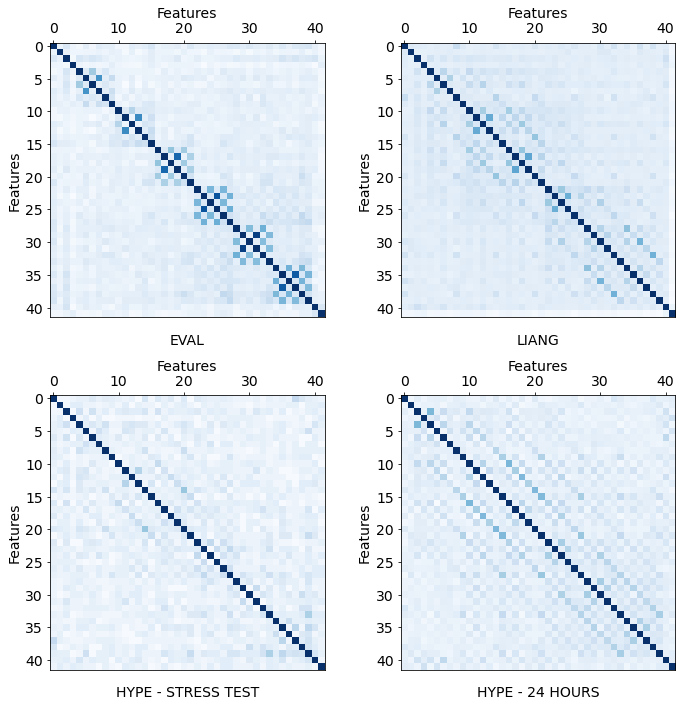

In [54]:
''' plot the NMI matrices '''
fig, axs = plt.subplots(2, int(len(nmi_matrices)/2), figsize=(10,10))
axes_idx = [[0,0],[0,1],[1,0],[1,1]]
fig_index = 0

BIGGER_SIZE = 14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels

if 'biking' in nmi_matrices.keys():
    nmi_matrices['hype - stress test'] = nmi_matrices['biking']
    del nmi_matrices['biking']
if '24 Hours' in nmi_matrices.keys():
    nmi_matrices['hype - 24 hours'] = nmi_matrices['24 Hours']
    del nmi_matrices['24 Hours']

for key in nmi_matrices:
    i, j = axes_idx[fig_index]
    ax = axs[i,j]
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Features')
    ax.set_ylabel('Features')
    ax.set_title(key.upper(), y=-0.12) #set title in the bottom
    _ = ax.imshow(nmi_matrices[key], cmap='Blues')     
    fig_index += 1

plt.tight_layout()
plt.savefig('nmi_matrices.pdf')

In [55]:
''' computes the mean nmi different between two given matrices '''    
def compute_mean_nmi_difference(nmi_matrix1, nmi_matrix2):    
    diff = nmi_matrix1 - nmi_matrix2
    return np.mean(np.absolute(diff))

cohorts = ['hype - 24 hours', 'hype - stress test', 'eval', 'liang']

''' now obtain the NMI differences '''
nmi_differences = defaultdict(lambda: {})
for cohort1, cohort2 in product([cohort for cohort in cohorts], [cohort for cohort in cohorts]):        
    if (cohort1 == cohort2): nmi_differences[cohort1][cohort2] = 0.0            
    elif not nmi_differences.get(cohort2):
        ''' calculate differences '''   
        nmi_differences[cohort1][cohort2] = compute_mean_nmi_difference(nmi_matrices[cohort1], nmi_matrices[cohort2])
        print(f"Calculated {cohort1} x {cohort2}")
print('Finished calculating mean differences')

print(nmi_differences)

Calculated hype - 24 hours x hype - stress test
Calculated hype - 24 hours x eval
Calculated hype - 24 hours x liang
Calculated hype - stress test x eval
Calculated hype - stress test x liang
Calculated eval x liang
Finished calculating mean differences
defaultdict(<function <lambda> at 0x7fb9b5b8d200>, {'hype - 24 hours': {'hype - 24 hours': 0.0, 'hype - stress test': 0.22596201884320935, 'eval': 0.07257719601870645, 'liang': 0.22097946751986056}, 'hype - stress test': {'hype - stress test': 0.0, 'eval': 0.16044705952203578, 'liang': 0.4467848608030655}, 'eval': {'eval': 0.0, 'liang': 0.28857848071431697}, 'liang': {'liang': 0.0}})


In [56]:
all_experiments_loso = pd.DataFrame()

# Liang
Training / Evaluating on Liang - LOSO

Experimenting in:  ../../features/liang/2021-05-14/liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv
Dataframe Shape: (359, 45)
Columns dropped:  11
New Dataframe Shape: (359, 34)
Nr of features:  31
Mean Error SBP: -0.15255831027576106
SD SBP: 17.885810703573995


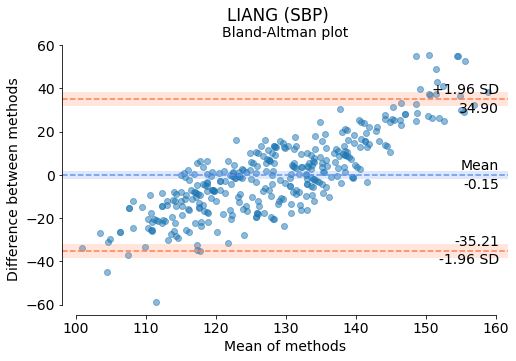

Dataframe Shape: (359, 45)
Columns dropped:  11
New Dataframe Shape: (359, 34)
Nr of features:  31
Mean Error DBP: -0.19597329903751967
SD DBP: 10.234276618855528


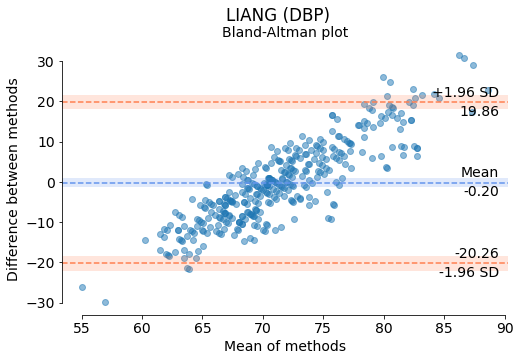

In [57]:
experiments = []
results = []

df_path = path_liang

print("Experimenting in: ", df_path)

df = pd.read_csv(df_path)

predicted_variables = ['SBP', 'DBP']

features = {
            'time_delta' : df['time_delta'].unique()[0], 
            'time_delta_type' : df['time_delta_type'].unique()[0],
            'motion_filter' : df['motion_filter'].unique()[0],
            'experiment_type' : df['experiment_type'].unique()[0],
            'special_filter' : df['special_filter'].unique()[0]
}

df.drop(features.keys(), axis=1, inplace=True)

for variable in predicted_variables:
    results, actual_predicted, shap_values = predict_bp_from_ppg_general(df,
                                    predicted_variable = variable, correlation_threshold = 0.9, k=1)
    
    error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
    print('Mean Error '+variable+':', error.mean())
    print('SD '+variable+':', error.std())
    
    shap_values.values = np.around(shap_values.values, decimals = 3)
    shap_values.base_values = np.around(shap_values.base_values, decimals = 3)
    shap_values.data = np.around(shap_values.data, decimals = 3)
    
#     plt.clf()
#     shap.plots.waterfall(shap_values, max_display=5, show=False)
#     plt.savefig("waterfall-eval-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
#     plt.clf()
#     shap.plots.force(shap_values, show=False, matplotlib=True)
#     plt.savefig("force-eval-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
    f, ax = plt.subplots(1, figsize = (8,5))
    pingouin.plot_blandaltman(actual_predicted[variable+'_actual'], 
                              actual_predicted[variable+'_predicted'],  
                              ax = ax)
    plt.suptitle('LIANG ('+variable+')')
    plt.savefig('bland-altman-liang-'+variable+'.pdf', format='pdf', dpi=300)
    plt.show()
    
    if results != 0:
        results.update(features)
        experiments.append(results)

all_experiments = pd.DataFrame.from_dict(experiments)

In [58]:
all_experiments[['predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
0,SBP,13.499775,10.733329,13.765766
1,DBP,7.891894,5.907690,8.035210


In [59]:
all_experiments_loso = all_experiments_loso.append(all_experiments)

# Experiment
Training / Evaluating on Eval - LOSO

Experimenting in:  ../../features/eval/2021-05-14/eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv
Dataframe Shape: (102, 45)
Columns dropped:  35
New Dataframe Shape: (102, 10)
Nr of features:  7
Mean Error SBP: 0.5112621237712469
SD SBP: 20.305536794435547


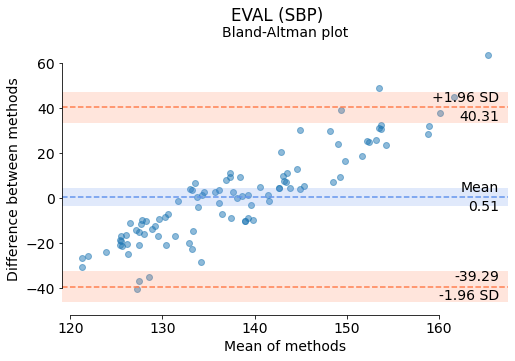

Dataframe Shape: (102, 45)
Columns dropped:  35
New Dataframe Shape: (102, 10)
Nr of features:  7
Mean Error DBP: 0.3072169933149607
SD DBP: 10.004418787214592


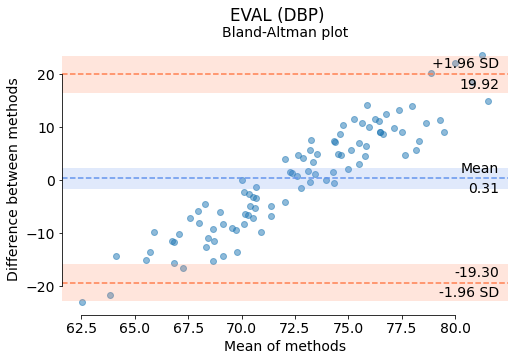

In [60]:
experiments = []
results = []

df_path = path_eval

print("Experimenting in: ", df_path)

df = pd.read_csv(df_path)

predicted_variables = ['SBP', 'DBP']

features = {
            'time_delta' : df['time_delta'].unique()[0], 
            'time_delta_type' : df['time_delta_type'].unique()[0],
            'motion_filter' : df['motion_filter'].unique()[0],
            'experiment_type' : df['experiment_type'].unique()[0],
            'special_filter' : df['special_filter'].unique()[0]
}

df.drop(features.keys(), axis=1, inplace=True)

for variable in predicted_variables:
    results, actual_predicted, shap_values = predict_bp_from_ppg_general(df,
                                    predicted_variable = variable, 
                                    correlation_threshold = 0.5, k=1)
    
    error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
    print('Mean Error '+variable+':', error.mean())
    print('SD '+variable+':', error.std())
    
    shap_values.values = np.around(shap_values.values, decimals = 3)
    shap_values.base_values = np.around(shap_values.base_values, decimals = 3)
    shap_values.data = np.around(shap_values.data, decimals = 3)
    
#     plt.clf()
#     shap.plots.waterfall(shap_values, max_display=5, show=False)
#     plt.savefig("waterfall-eval-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
#     plt.clf()
#     shap.plots.force(shap_values, show=False, matplotlib=True)
#     plt.savefig("force-eval-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
    f, ax = plt.subplots(1, figsize = (8,5))
    pingouin.plot_blandaltman(actual_predicted[variable+'_actual'], 
                               actual_predicted[variable+'_predicted'],  ax = ax)
    plt.suptitle('EVAL ('+variable+')')
    plt.savefig('bland-altman-eval-'+variable+'.pdf', format='pdf', dpi=300)
    plt.show()
    
    if results != 0:
        results.update(features)
        experiments.append(results)

all_experiments = pd.DataFrame.from_dict(experiments)

In [61]:
all_experiments[['predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
0,SBP,15.170197,8.018785,17.281350
1,DBP,7.838917,3.797660,8.457443


In [62]:
all_experiments_loso = all_experiments_loso.append(all_experiments)

# Experiment
Training / Evaluating on HYPE 24 Hours - LOSO

Experimenting in:  ../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
DF shape:  (132, 57)
Dataframe Shape: (132, 45)
Columns dropped:  33
New Dataframe Shape: (132, 12)
Nr of features:  9
Mean Error SBP: -0.05689538437758401
SD SBP: 21.90457479380601


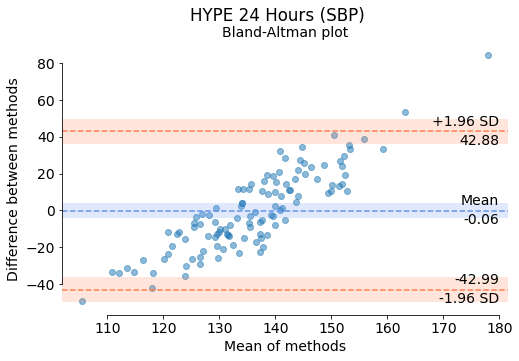

Dataframe Shape: (132, 45)
Columns dropped:  33
New Dataframe Shape: (132, 12)
Nr of features:  9
Mean Error DBP: -0.10068621954240853
SD DBP: 16.173822779249235


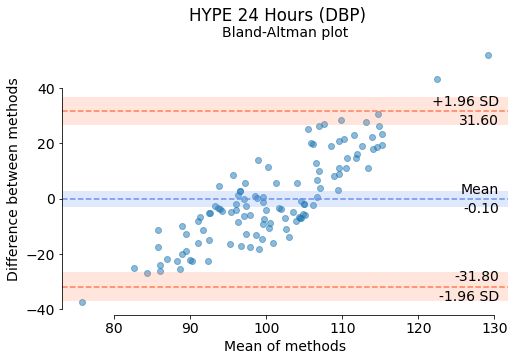

In [63]:
experiments = []
results = []

df_path = path_24_hours

print("Experimenting in: ", df_path)

df = pd.read_csv(df_path)

print("DF shape: ", df.shape)

predicted_variables = ['SBP', 'DBP']

features = {
            'time_delta' : df['time_delta'].unique()[0], 
            'time_delta_type' : df['time_delta_type'].unique()[0],
            'motion_filter' : df['motion_filter'].unique()[0],
            'bp_monitor' : df['bp_monitor'].unique()[0], 
            'timeshift' : df['timeshift'].unique()[0],
            'experiment_type' : df['experiment_type'].unique()[0],
            'special_filter' : df['special_filter'].unique()[0]
}

df.drop(features.keys(), axis=1, inplace=True)

for variable in predicted_variables:
    results, actual_predicted, shap_values = predict_bp_from_ppg_general(df,
                                    predicted_variable = variable, correlation_threshold = 0.75, k=1)
    
    error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
    print('Mean Error '+variable+':', error.mean())
    print('SD '+variable+':', error.std())
    
    shap_values.values = np.around(shap_values.values, decimals = 3)
    shap_values.base_values = np.around(shap_values.base_values, decimals = 3)
    shap_values.data = np.around(shap_values.data, decimals = 3)
    
#     plt.clf()
#     shap.plots.waterfall(shap_values, max_display=5, show=False)
#     plt.savefig("waterfall-hype-24-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
#     plt.clf()
#     shap.plots.force(shap_values, show=False, text_rotation=5, matplotlib=True)
#     plt.savefig("force-hype-24-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
    f, ax = plt.subplots(1, figsize = (8,5))
    pingouin.plot_blandaltman(actual_predicted[variable+'_actual'], 
                               actual_predicted[variable+'_predicted'],  ax = ax)
    plt.suptitle('HYPE 24 Hours ('+variable+')')
    plt.savefig('bland-altman-hype-24-'+variable+'.pdf', format='pdf', dpi=300)
    plt.show()
    
    if results != 0:
        results.update(features)
        experiments.append(results)

all_experiments = pd.DataFrame.from_dict(experiments)

In [64]:
all_experiments[['predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
0,SBP,17.924938,5.257668,20.938926
1,DBP,12.580623,4.136858,15.047790


In [65]:
all_experiments_loso = all_experiments_loso.append(all_experiments)

# Experiment
Training / Evaluating on HYPE Stress Test - LOSO

Experimenting in:  ../../features/hype/2021-05-14/biking/15seconds-bfill-cheby/motion-not-filtered/all_features_biking_15seconds-bfill-cheby.csv
DF shape:  (54, 57)
Dataframe Shape: (54, 45)
Columns dropped:  37
New Dataframe Shape: (54, 8)
Nr of features:  5
Mean Error SBP: 0.058619892129396924
SD SBP: 11.377774976868428


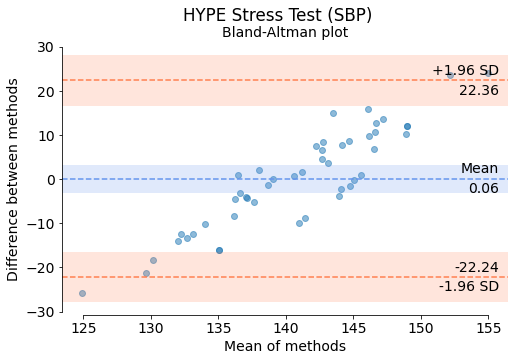

Dataframe Shape: (54, 45)
Columns dropped:  37
New Dataframe Shape: (54, 8)
Nr of features:  5
Mean Error DBP: 2.3367035923098025
SD DBP: 9.372901432124893


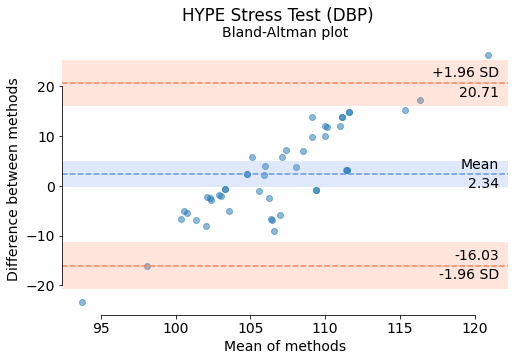

In [66]:
experiments = []
results = []

df_path = path_biking

print("Experimenting in: ", df_path)

df = pd.read_csv(df_path)

print("DF shape: ", df.shape)

predicted_variables = ['SBP', 'DBP']

features = {
            'time_delta' : df['time_delta'].unique()[0], 
            'time_delta_type' : df['time_delta_type'].unique()[0],
            'motion_filter' : df['motion_filter'].unique()[0],
            'bp_monitor' : df['bp_monitor'].unique()[0], 
            'timeshift' : df['timeshift'].unique()[0],
            'experiment_type' : df['experiment_type'].unique()[0],
            'special_filter' : df['special_filter'].unique()[0]
}

df.drop(features.keys(), axis=1, inplace=True)

for variable in predicted_variables:
    results, actual_predicted, shap_values = predict_bp_from_ppg_general(df,
                                    predicted_variable = variable, correlation_threshold = 0.6, k=1)
    
    error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
    print('Mean Error '+variable+':', error.mean())
    print('SD '+variable+':', error.std())
    
    shap_values.values = np.around(shap_values.values, decimals = 3)
    shap_values.base_values = np.around(shap_values.base_values, decimals = 3)
    shap_values.data = np.around(shap_values.data, decimals = 3)
    
#     plt.clf()
#     shap.plots.waterfall(shap_values, max_display=5, show=False)
#     plt.savefig("waterfall-hype-biking-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
#     plt.clf()
#     shap.plots.force(shap_values, show=False, matplotlib=True)
#     plt.savefig("force-hype-biking-"+variable+".pdf", dpi=300, bbox_inches='tight')
#     plt.show()
    
    f, ax = plt.subplots(1, figsize = (8,5))
    pingouin.plot_blandaltman(actual_predicted[variable+'_actual'], 
                               actual_predicted[variable+'_predicted'],  ax = ax)
    plt.suptitle('HYPE Stress Test ('+variable+')')
    plt.savefig('bland-altman-stress-test-'+variable+'.pdf', format='pdf', dpi=300)
    plt.show()
        
    if results != 0:
        results.update(features)
        experiments.append(results)

all_experiments = pd.DataFrame.from_dict(experiments)

In [67]:
all_experiments[['predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
0,SBP,11.328386,6.193131,12.963429
1,DBP,7.349190,4.346125,8.282247


In [68]:
all_experiments_loso = all_experiments_loso.append(all_experiments)

In [69]:
all_experiments_loso['validation'] = 'Leave-One-Subject-Out Cross-Validation'

In [70]:
all_experiments_loso = all_experiments_loso.sort_values(by=['experiment_type', 'predicted_variable'])

In [71]:
all_experiments_loso[['experiment_type', 'predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,experiment_type,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
1,24 Hours,DBP,12.580623,4.136858,15.047790
0,24 Hours,SBP,17.924938,5.257668,20.938926
1,biking,DBP,7.349190,4.346125,8.282247
0,biking,SBP,11.328386,6.193131,12.963429
1,eval,DBP,7.838917,3.797660,8.457443
0,eval,SBP,15.170197,8.018785,17.281350
1,liang,DBP,7.891894,5.907690,8.035210
0,liang,SBP,13.499775,10.733329,13.765766


# Cross-Validation
All Datasets

In [72]:
experiments = []
results = []

paths = [path_24_hours, path_biking, path_eval, path_liang]

correlation_threshold = {
    '24 Hours': 0.75,
    'biking': 0.6, 
    'eval': 0.5, 
    'liang': 0.9,
}

for path in paths:
    df_path = path

    print("Experimenting in: ", df_path)

    df = pd.read_csv(df_path)

    predicted_variables = ['SBP', 'DBP']

    features = {
                'time_delta' : df['time_delta'].unique()[0], 
                'time_delta_type' : df['time_delta_type'].unique()[0],
                'motion_filter' : df['motion_filter'].unique()[0],
                'experiment_type' : df['experiment_type'].unique()[0],
                'special_filter' : df['special_filter'].unique()[0]
    }
    
    if (df['experiment_type'].unique()[0] != 'eval') & (df['experiment_type'].unique()[0] != 'liang'):
        features['bp_monitor'] = df['bp_monitor'].unique()[0]
        features['timeshift'] = df['timeshift'].unique()[0]
    elif df['experiment_type'].unique()[0] == 'liang':
        features['class'] = df['class'].unique()[0]
        features['segment'] = df['segment'].unique()[0]

    df.drop(features.keys(), axis=1, inplace=True)

    for variable in predicted_variables:
        results, actual_predicted = predict_bp_from_ppg_cross(df,
                                        predicted_variable = variable, 
                                        correlation_threshold = correlation_threshold[features['experiment_type']])

        error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
        print('Mean Error '+variable+':', error.mean())
        print('SD '+variable+':', error.std())

        if results != 0:
            results.update(features)
            experiments.append(results)

all_experiments_cross = pd.DataFrame.from_dict(experiments)
all_experiments_cross['validation'] = '10-Fold Cross-Validation'

Experimenting in:  ../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
Dataframe Shape: (132, 45)
Columns dropped:  33
New Dataframe Shape: (132, 12)
Total BP Pairs:  132
Total Subjects:  9
Nr of features:  9
Index(['SBP', 'DBP', 'patientid', 'Systolic Upstroke Time μ',
       'Systolic Upstroke Time σ2', 'Diastolic Time μ', 'Diastolic Time σ2',
       'DW/SW Ratio 10 μ', 'Diastolic Width 66% σ2', 'Diastolic Width 75% μ',
       'DW/SW Ratio 75 μ', 'Cardiac Period μ'],
      dtype='object')


Mean Error SBP: 0.0397975590041368
SD SBP: 19.599638093404028
Dataframe Shape: (132, 45)
Columns dropped:  33
New Dataframe Shape: (132, 12)
Total BP Pairs:  132
Total Subjects:  9
Nr of features:  9
Index(['SBP', 'DBP', 'patientid', 'Systolic Upstroke Time μ',
       'Systolic Upstroke Time σ2', 'Diastolic Time μ', 'Diastolic Time σ2',
       'DW/SW Ratio 10 μ', 'Diastolic Width 66% σ2', 'Diastolic Width 75% μ',
       'DW/SW R

# Compare LOSO to 10-Fold Cross-Validation

In [73]:
all_experiments_cross[['experiment_type', 'predicted_variable', 'MAE_LGBM_MEAN',
                 'MAE_LGBM_STD', 'validation']].sort_values(by=['experiment_type', 
                                                        'predicted_variable']).round(2)

,experiment_type,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,validation
1,24 Hours,DBP,11.06,2.34,10-Fold Cross-Validation
0,24 Hours,SBP,15.26,4.36,10-Fold Cross-Validation
3,biking,DBP,7.13,2.01,10-Fold Cross-Validation
2,biking,SBP,9.33,2.93,10-Fold Cross-Validation
5,eval,DBP,7.42,1.91,10-Fold Cross-Validation
4,eval,SBP,15.26,3.46,10-Fold Cross-Validation
7,liang,DBP,8.06,1.04,10-Fold Cross-Validation
6,liang,SBP,13.88,2.55,10-Fold Cross-Validation


In [74]:
all_experiments_loso[['experiment_type', 'predicted_variable', 'MAE_LGBM_MEAN',
                      'MAE_LGBM_STD', 'validation']].sort_values(by=['experiment_type', 
                                                        'predicted_variable']).round(2)

,experiment_type,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,validation
1,24 Hours,DBP,12.58,4.14,Leave-One-Subject-Out Cross-Validation
0,24 Hours,SBP,17.92,5.26,Leave-One-Subject-Out Cross-Validation
1,biking,DBP,7.35,4.35,Leave-One-Subject-Out Cross-Validation
0,biking,SBP,11.33,6.19,Leave-One-Subject-Out Cross-Validation
1,eval,DBP,7.84,3.80,Leave-One-Subject-Out Cross-Validation
0,eval,SBP,15.17,8.02,Leave-One-Subject-Out Cross-Validation
1,liang,DBP,7.89,5.91,Leave-One-Subject-Out Cross-Validation
0,liang,SBP,13.50,10.73,Leave-One-Subject-Out Cross-Validation


# Feature Importance on Training
Training and Testing on the Same Dataset

Training in:  ../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
Testing in:  ../../features/hype/2021-05-14/24Hours/15seconds-bfill-norm/motion-filtered/all_features_24Hours_15seconds-bfill-norm.csv
Train shape:  (132, 58)
Test shape:  (132, 58)
Dataframe Shape: (264, 46)
Columns dropped:  33
New Dataframe Shape: (264, 13)
Nr of features:  10


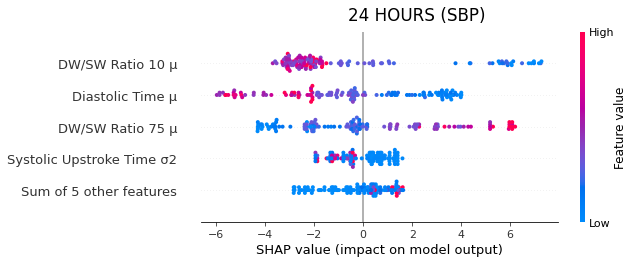

Mean Error SBP: -8.672384023033043e-10
SD SBP: 17.058779533072915
Dataframe Shape: (264, 46)
Columns dropped:  33
New Dataframe Shape: (264, 13)
Nr of features:  10


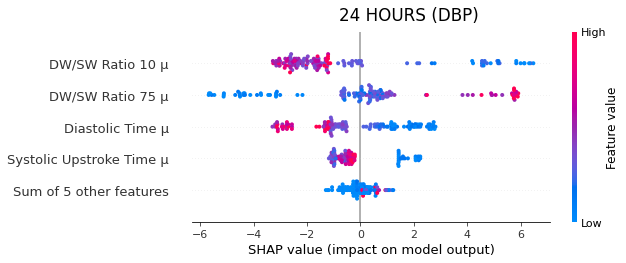

Mean Error DBP: 2.1204899116073096e-10
SD DBP: 12.514739465487327
Training in:  ../../features/hype/2021-05-14/biking/15seconds-bfill-cheby/motion-not-filtered/all_features_biking_15seconds-bfill-cheby.csv
Testing in:  ../../features/hype/2021-05-14/biking/15seconds-bfill-cheby/motion-not-filtered/all_features_biking_15seconds-bfill-cheby.csv
Train shape:  (54, 58)
Test shape:  (54, 58)
Dataframe Shape: (108, 46)
Columns dropped:  37
New Dataframe Shape: (108, 9)
Nr of features:  6


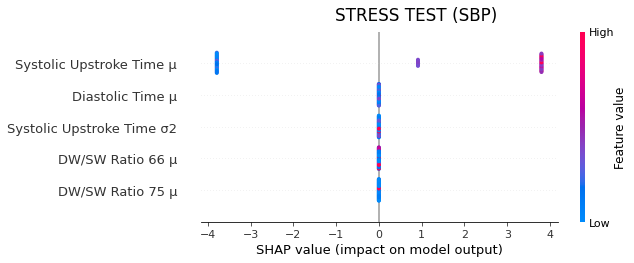

Mean Error SBP: 8.208768644248334e-09
SD SBP: 10.500509537908936
Dataframe Shape: (108, 46)
Columns dropped:  37
New Dataframe Shape: (108, 9)
Nr of features:  6


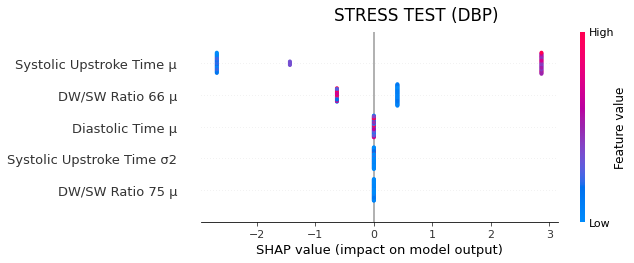

Mean Error DBP: -1.308713664187693e-09
SD DBP: 8.697190781287347
Training in:  ../../features/eval/2021-05-14/eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv
Testing in:  ../../features/eval/2021-05-14/eval/15seconds-bfill-norm/motion-not-filtered/all_features_eval_15seconds-bfill-norm.csv
Train shape:  (103, 51)
Test shape:  (103, 51)
Dataframe Shape: (204, 46)
Columns dropped:  35
New Dataframe Shape: (204, 11)
Nr of features:  8


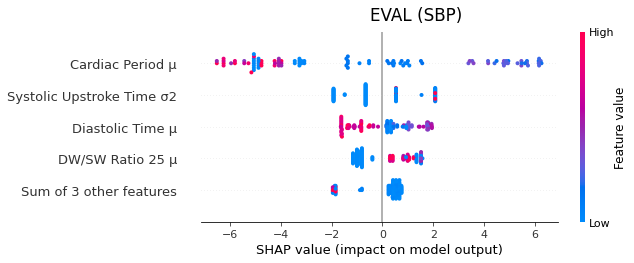

Mean Error SBP: 7.145418374634841e-10
SD SBP: 17.083517406564674
Dataframe Shape: (204, 46)
Columns dropped:  35
New Dataframe Shape: (204, 11)
Nr of features:  8


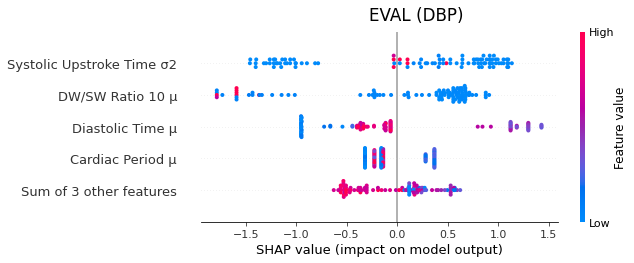

Mean Error DBP: 3.7033208743606317e-10
SD DBP: 7.907458572444483
Training in:  ../../features/liang/2021-05-14/liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv
Testing in:  ../../features/liang/2021-05-14/liang/2.1sec-ffill-cheby/motion-not-filtered/all_patients_with_bp.csv
Train shape:  (359, 53)
Test shape:  (359, 53)
Dataframe Shape: (718, 46)
Columns dropped:  11
New Dataframe Shape: (718, 35)
Nr of features:  32


Permutation explainer: 360it [00:37,  7.15it/s]                         


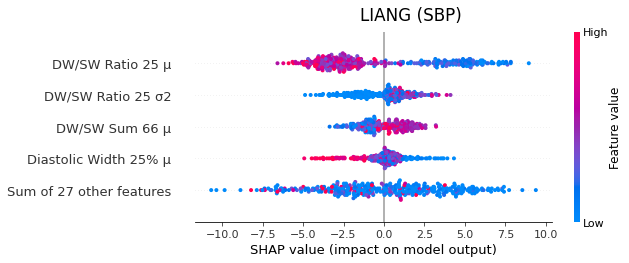

Mean Error SBP: -1.5962050029000107e-09
SD SBP: 14.595412519043515
Dataframe Shape: (718, 46)
Columns dropped:  11
New Dataframe Shape: (718, 35)
Nr of features:  32


Permutation explainer: 360it [00:39,  6.83it/s]                         


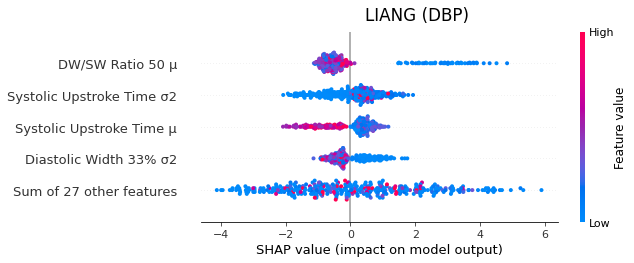

Mean Error DBP: -4.288444857659145e-10
SD DBP: 8.190029689164234


In [75]:
experiments = []

paths = [path_24_hours, path_biking, path_eval, path_liang]

correlation_threshold = {
    '24 Hours': 0.75,
    'biking': 0.6, 
    'eval': 0.5, 
    'liang': 0.9,
}

for path in paths:
    results = []

    train_path = path
    test_path = path

    print("Training in: ", train_path)
    print("Testing in: ", test_path)

    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    df_train['df_type'] = 'train'
    df_test['df_type'] = 'test'

    print("Train shape: ", df_train.shape)
    print("Test shape: ", df_test.shape)

    df = df_train.append(df_test)
    experiment_type = df['experiment_type'].unique()[0]
    if experiment_type == 'biking':
        experiment_type = 'stress test'
    
    features = {
                'time_delta' : df['time_delta'].unique()[0], 
                'time_delta_type' : df['time_delta_type'].unique()[0],
                'motion_filter' : df['motion_filter'].unique()[0],
                'experiment_type' : df['experiment_type'].unique()[0],
                'special_filter' : df['special_filter'].unique()[0]
    }


    if (df['experiment_type'].unique()[0] != 'eval') & (df['experiment_type'].unique()[0] != 'liang'):
        features['bp_monitor'] = df['bp_monitor'].unique()[0]
        features['timeshift'] = df['timeshift'].unique()[0]
    elif df['experiment_type'].unique()[0] == 'liang':
        features['class'] = df['class'].unique()[0]
        features['segment'] = df['segment'].unique()[0]

    df.drop(features.keys(), axis=1, inplace=True)

    predicted_variables = ['SBP', 'DBP']
    for variable in predicted_variables:
        results, actual_predicted = predict_bp_from_ppg(df,
            experiment_type = experiment_type,
            predicted_variable = variable, 
            correlation_threshold = correlation_threshold[features['experiment_type']],
            )

        error = actual_predicted[variable+'_actual'] - actual_predicted[variable+'_predicted']
        print('Mean Error '+variable+':', error.mean())
        print('SD '+variable+':', error.std())

        if results != 0:
            results.update(features)
            experiments.append(results)

all_experiments = pd.DataFrame.from_dict(experiments)

In [76]:
all_experiments[['experiment_type', 'predicted_variable', 'MAE_LGBM_MEAN','MAE_LGBM_STD','RMSE_LGBM_MEAN']]

,experiment_type,predicted_variable,MAE_LGBM_MEAN,MAE_LGBM_STD,RMSE_LGBM_MEAN
0,24 Hours,SBP,13.057656,0.0,16.994040
1,24 Hours,DBP,9.626565,0.0,12.467245
2,biking,SBP,8.284208,0.0,10.402828
3,biking,DBP,6.746310,0.0,8.616285
4,eval,SBP,13.563655,0.0,16.999568
5,eval,DBP,6.539582,0.0,7.868601
6,liang,SBP,11.229866,0.0,14.575070
7,liang,DBP,6.424973,0.0,8.178615
